# Music Genre Classification
## Exploratory Data Analysis and Feature Extraction
---

In [362]:
#Imports
%matplotlib inline
import librosa
import librosa.display
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#ignore fragmented dataframe warnings
import warnings
warnings.filterwarnings("ignore")

## Table of Contents

* #### [EDA - Part 1](#e1)
* #### [Feature Extraction & Engineering](#f)
* #### [EDA - Part 2](#e2)
* #### [Summary](#su)

## Helper Functions

In [357]:
#list of genres and image types to loop through for directory and data creation
folder_list = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal',
                  'pop', 'reggae', 'rock']
image_list = ['chroma_cens', 'mfccs', 'spectrograms', 'waveforms']

In [371]:
#create directories for images
def create_directories():
    #create image sub-directories
    for image in image_list:
        os.mkdir(f'../images/{image}')
        for folder in folder_list:
            os.mkdir(f'../images/{image}/{folder}')

In [306]:
#create 4 image types for use in modeling
def create_images():
    for folder in folder_list:
        for i in range(100):
            if len(str(i)) < 2 :
                folder_num = '0' + str(i)
            else:
                folder_num = str(i)
            audio_path = f'../genres/{folder}/{folder}.000{folder_num}.au'
            x,sr = librosa.load(audio_path)
            
            #waveplot
            plt.figure(figsize=(14, 5))
            librosa.display.waveshow(x, sr=sr)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel("")
            plt.savefig(f'../images/waveforms/{folder}/{folder}.000{folder_num}_waveform.png')
            plt.close()
            
            #spectogram
            plt.figure(figsize=(14, 5))
            S = librosa.stft(x)
            Xmag = librosa.amplitude_to_db(np.abs(S))
            librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log')
            plt.xticks([])
            plt.yticks([])
            plt.xlabel("")
            plt.ylabel("")
            plt.savefig(f'../images/spectrograms/{folder}/{folder}.000{folder_num}_spectrogram.png')
            plt.close()
            
            #chroma_sens
            chroma_cens = librosa.feature.chroma_cens(y=x, sr=sr)
            librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
            plt.xticks([])
            plt.yticks([])
            plt.xlabel("")
            plt.ylabel("")
            plt.savefig(f'../images/chroma_cens/{folder}/{folder}.000{folder_num}_chroma_cens.png')
            plt.close()
            
            #mfccs
            plt.figure(figsize=(14, 5))
            mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40)
            librosa.display.specshow(mfccs, x_axis='time')
            plt.xticks([])
            plt.yticks([])
            plt.xlabel("")
            plt.ylabel("")
            plt.savefig(f'../images/mfccs/{folder}/{folder}.000{folder_num}_mfccs.png')
            plt.close()

In [307]:
#calculate amplitude envelope
def ae(signal):
    amplitude_envelope = []
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), 512): 
        amplitude_envelope_current_frame = max(signal[i:i+1024]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope) 

As referenced in the previous notebook, features were chosen with help from research and librosa documentation. The vast majority of the extracted features are presented as arrays. They represent a specific value of the audio signal at some point in time. There are many ways to engineer these features for modeling. For this project, simple aggregation was used. For example, the mean and standard deviation will describe the average value of the feature over the entire duration and how strongly the values deviate from the mean. In some cases, the minimum and maximum value were taken when appropriate.

In [358]:
#create feature dataset
#may take over an hour to run
def create_dataset():
    #empty dataframe
    df = pd.DataFrame()

    #loop through every track
    for folder in folder_list:
        track_list = os.listdir(f'../genres/{folder}')
        for track in track_list:
            i = len(df)
            #file name and genre
            df.loc[i,"file_name"] = track 
            df.loc[i,"genre"] = folder
            
            #set audio path and extract audio time series and sample rate
            audio_path = f'../genres/{folder}/{track}'
            x,sr = librosa.load(audio_path)
            
            #extract tempo
            df.loc[i,'global_tempo'] = np.round(librosa.feature.tempo(y = x, sr = sr)[0])
            
            #extract zero crossing
            df.loc[i,'zero_crossings'] = sum(librosa.zero_crossings(x, pad=False))
            df.loc[i, 'avg_zc_rate'] =  np.mean(librosa.feature.zero_crossing_rate(x + 0.0001))
            df.loc[i, 'std_zc_rate'] =  np.std(librosa.feature.zero_crossing_rate(x + 0.0001))
            
            #extract root mean squared energy
            S = librosa.magphase(librosa.stft(y = x, window=np.ones, center=False))[0]
            df.loc[i, 'avg_rms'] =  np.mean(librosa.feature.rms(S=S))
            df.loc[i, 'std_rms'] =  np.std(librosa.feature.rms(S=S))
            
            #extract amplitude envelope
            df.loc[i, 'avg_amplitude_envelope'] =  np.mean(ae(x))
            df.loc[i, 'std_amplitude_envelope'] =  np.std(ae(x))
            
            #extract autocorrelation
            df.loc[i, 'avg_autocorrelation'] =  np.mean(librosa.autocorrelate(y=x))
            df.loc[i, 'std_autocorrelation'] =  np.std(librosa.autocorrelate(y=x))
    
            #extract spectral rolloff
            df.loc[i, 'avg_rolloff'] =  np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr))
            df.loc[i, 'std_rolloff'] =  np.std(librosa.feature.spectral_rolloff(y=x, sr=sr))
            df.loc[i, 'avg_max_rolloff'] =  np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.99))
            df.loc[i, 'std_max_rolloff'] =  np.std(librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.99))
            df.loc[i, 'avg_min_rolloff'] =  np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01))
            df.loc[i, 'std_min_rolloff'] =  np.std(librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01))
    
            #extract spectral centroid
            df.loc[i, 'avg_spectral_centroid'] =  np.mean(librosa.feature.spectral_centroid(y=x, sr=sr))
            df.loc[i, 'std_spectral_centroid'] =  np.std(librosa.feature.spectral_centroid(y=x, sr=sr))
    
            #extract spectral bandwidth
            df.loc[i, 'avg_spectral_bandwidth'] =  np.mean(librosa.feature.spectral_bandwidth(y=x, sr=sr))
            df.loc[i, 'std_spectral_bandwidth'] =  np.std(librosa.feature.spectral_bandwidth(y=x, sr=sr))
            
            #extract chromagram
            df.loc[i, 'avg_chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=x, sr=sr))
            df.loc[i, 'std_chroma_stft'] = np.std(librosa.feature.chroma_stft(y=x, sr=sr))
    
            #extract harmonic and percussive components
            harmonic, percussive = librosa.effects.hpss(y = x)
            df.loc[i, 'avg_harmonic_comp'] =  np.mean(harmonic)
            df.loc[i, 'std_harmonic_comp'] =  np.std(harmonic)
            df.loc[i, 'avg_percussive_comp'] =  np.mean(percussive)
            df.loc[i, 'std_percussive_comp'] =  np.std(percussive)
    
            #extract spectral flatness
            df.loc[i, 'avg_spectral_flatness'] =  np.mean(librosa.feature.spectral_flatness(y=x))
            df.loc[i, 'std_spectral_flatness'] =  np.std(librosa.feature.spectral_flatness(y=x))
            
            #extract tonnetz
            df.loc[i, 'avg_tonnetz'] =  np.mean(librosa.feature.tonnetz(y=x, sr=sr))
            df.loc[i, 'std_tonnetz'] =  np.std(librosa.feature.tonnetz(y=x, sr=sr))
    
            #extract spectral contrast
            df.loc[i, 'avg_spectral_contrast'] =  np.mean(librosa.feature.spectral_contrast(y=x,sr=sr))
            df.loc[i, 'std_spectral_contrast'] =  np.std(librosa.feature.spectral_contrast(y=x,sr=sr))
    
            #extract mel-scale spectogram
            df.loc[i, 'avg_mel'] =  np.mean(librosa.feature.melspectrogram(y=x, sr=sr))
            df.loc[i, 'std_mel'] =  np.std(librosa.feature.melspectrogram(y=x, sr=sr))
    
            #extract first 25 mel frequency cepstral coefficients and first/second order derivatives
            for j in range(1,26):
                df.loc[i, f'avg_mfcc_{j}'] =  np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc = j))
                df.loc[i, f'std_mfcc_{j}'] =  np.std(librosa.feature.mfcc(y=x, sr=sr, n_mfcc = j))
        
                A = librosa.feature.mfcc(y=x, sr=sr, n_mfcc = j)
                df.loc[i, f'avg_delta1_mfcc_{j}'] =  np.mean(librosa.feature.delta(A))
                df.loc[i, f'std_delta1_mfcc_{j}'] =  np.std(librosa.feature.delta(A))
                df.loc[i, f'avg_delta2_mfcc_{j}'] =  np.mean(librosa.feature.delta(A, order = 2))
                df.loc[i, f'std_delta2_mfcc_{j}'] =  np.std(librosa.feature.delta(A, order = 2))
      
    #sort based on file name
    df.sort_values('file_name', inplace = True)
    df = df.reset_index(drop=True)
    return df.copy()

## Exploratory Data Analysis - Part 1<a id='e1'></a>

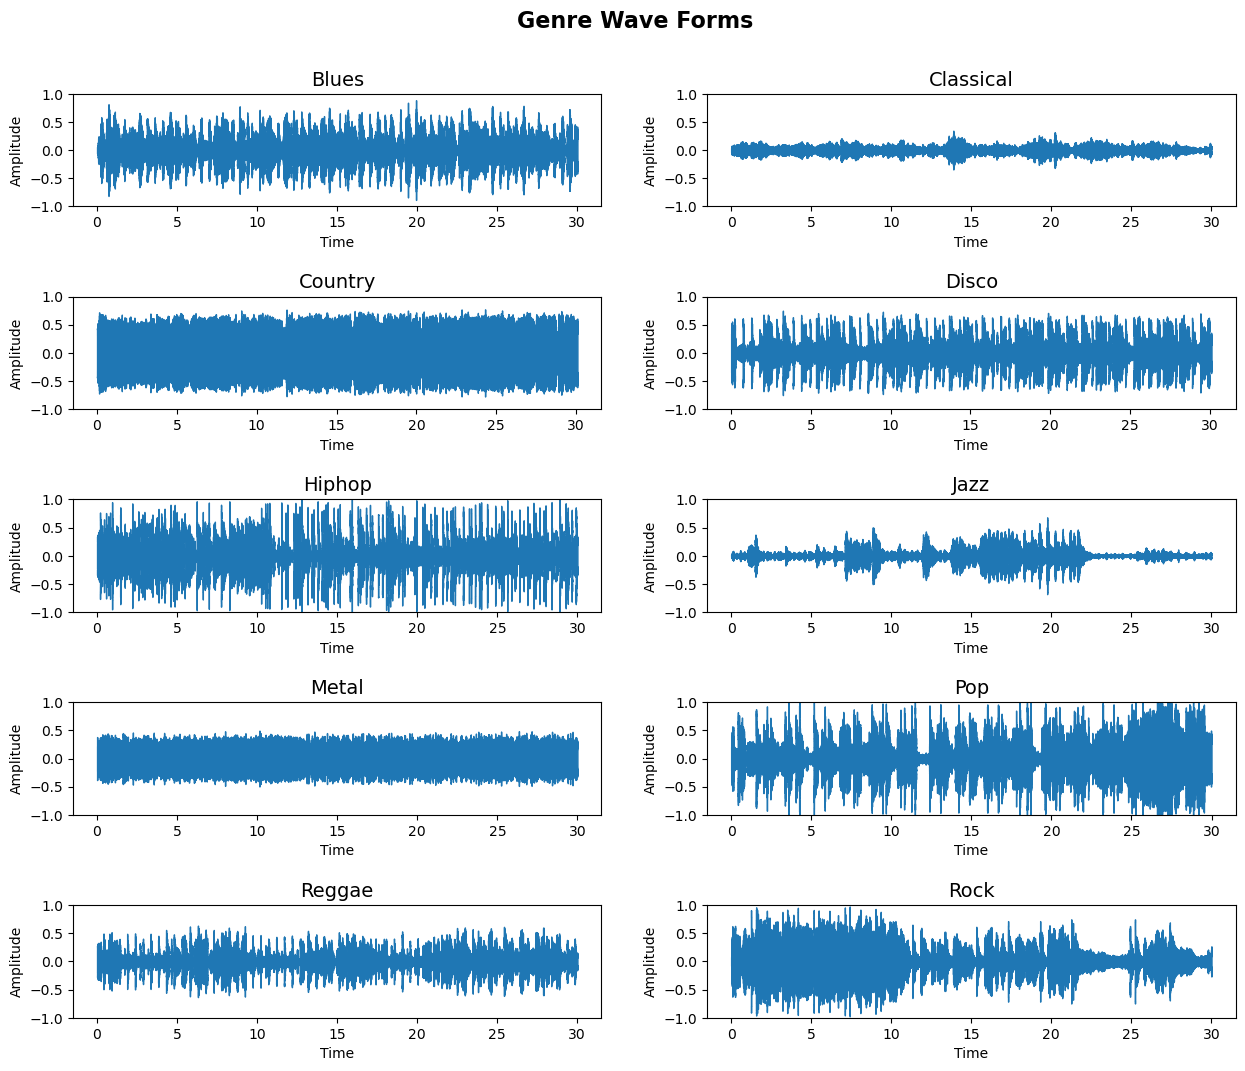

In [296]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Genre Wave Forms", fontsize=16, y=0.95, fontweight = 'bold')

# loop through genres and axes
#plot wave forms
for genre, ax in zip(folder_list, axs.ravel()):
    audio_path = f'../genres/{genre}/{genre}.00000.au'
    x,sr = librosa.load(audio_path)
    librosa.display.waveshow(x, sr=sr, ax=ax)
    ax.set_title(genre.title(), fontsize = 14)
    ax.set_ylim((-1,1))
    ax.set_ylabel("Amplitude")

plt.show()

Example wave forms from each of the 10 genres. Classical and Jazz sample appear to have lowest overall loudness. Country, Hip-Hop, and Pop have high, consistent loudness. Metal is extremely consistent in entire duration.

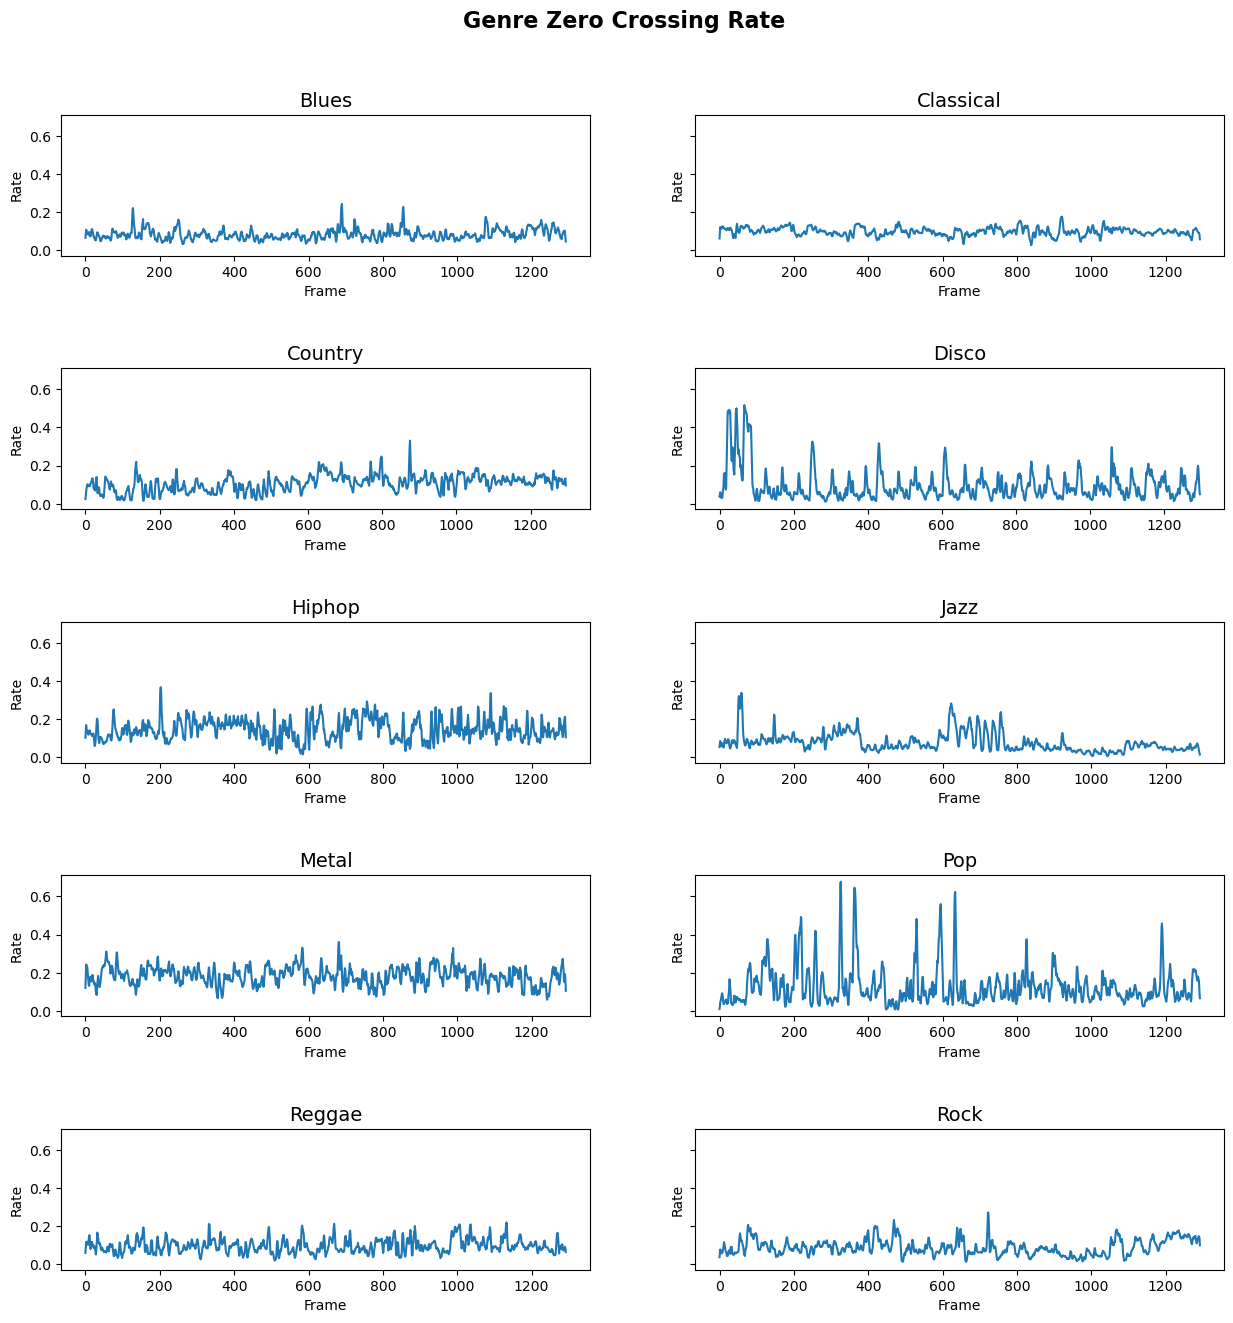

In [350]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15), sharey = True)
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Genre Zero Crossing Rate", fontsize=16, y=0.95, fontweight = 'bold')

# plot zero crossing rate
for genre, ax in zip(folder_list, axs.ravel()):
    audio_path = f'../genres/{genre}/{genre}.00000.au'
    x,sr = librosa.load(audio_path)
    zcr = librosa.feature.zero_crossing_rate(y = x)
    ax.plot(zcr.T)
    ax.set_ylabel("Rate")
    ax.set_xlabel("Frame")
    ax.set_title(genre.title(), fontsize = 14)

plt.show()

Plots of zero crossing rates of samples from each genre. Pop seems to have the highest variation amongst these sample. Classical and Reggae seem to be low throughout.

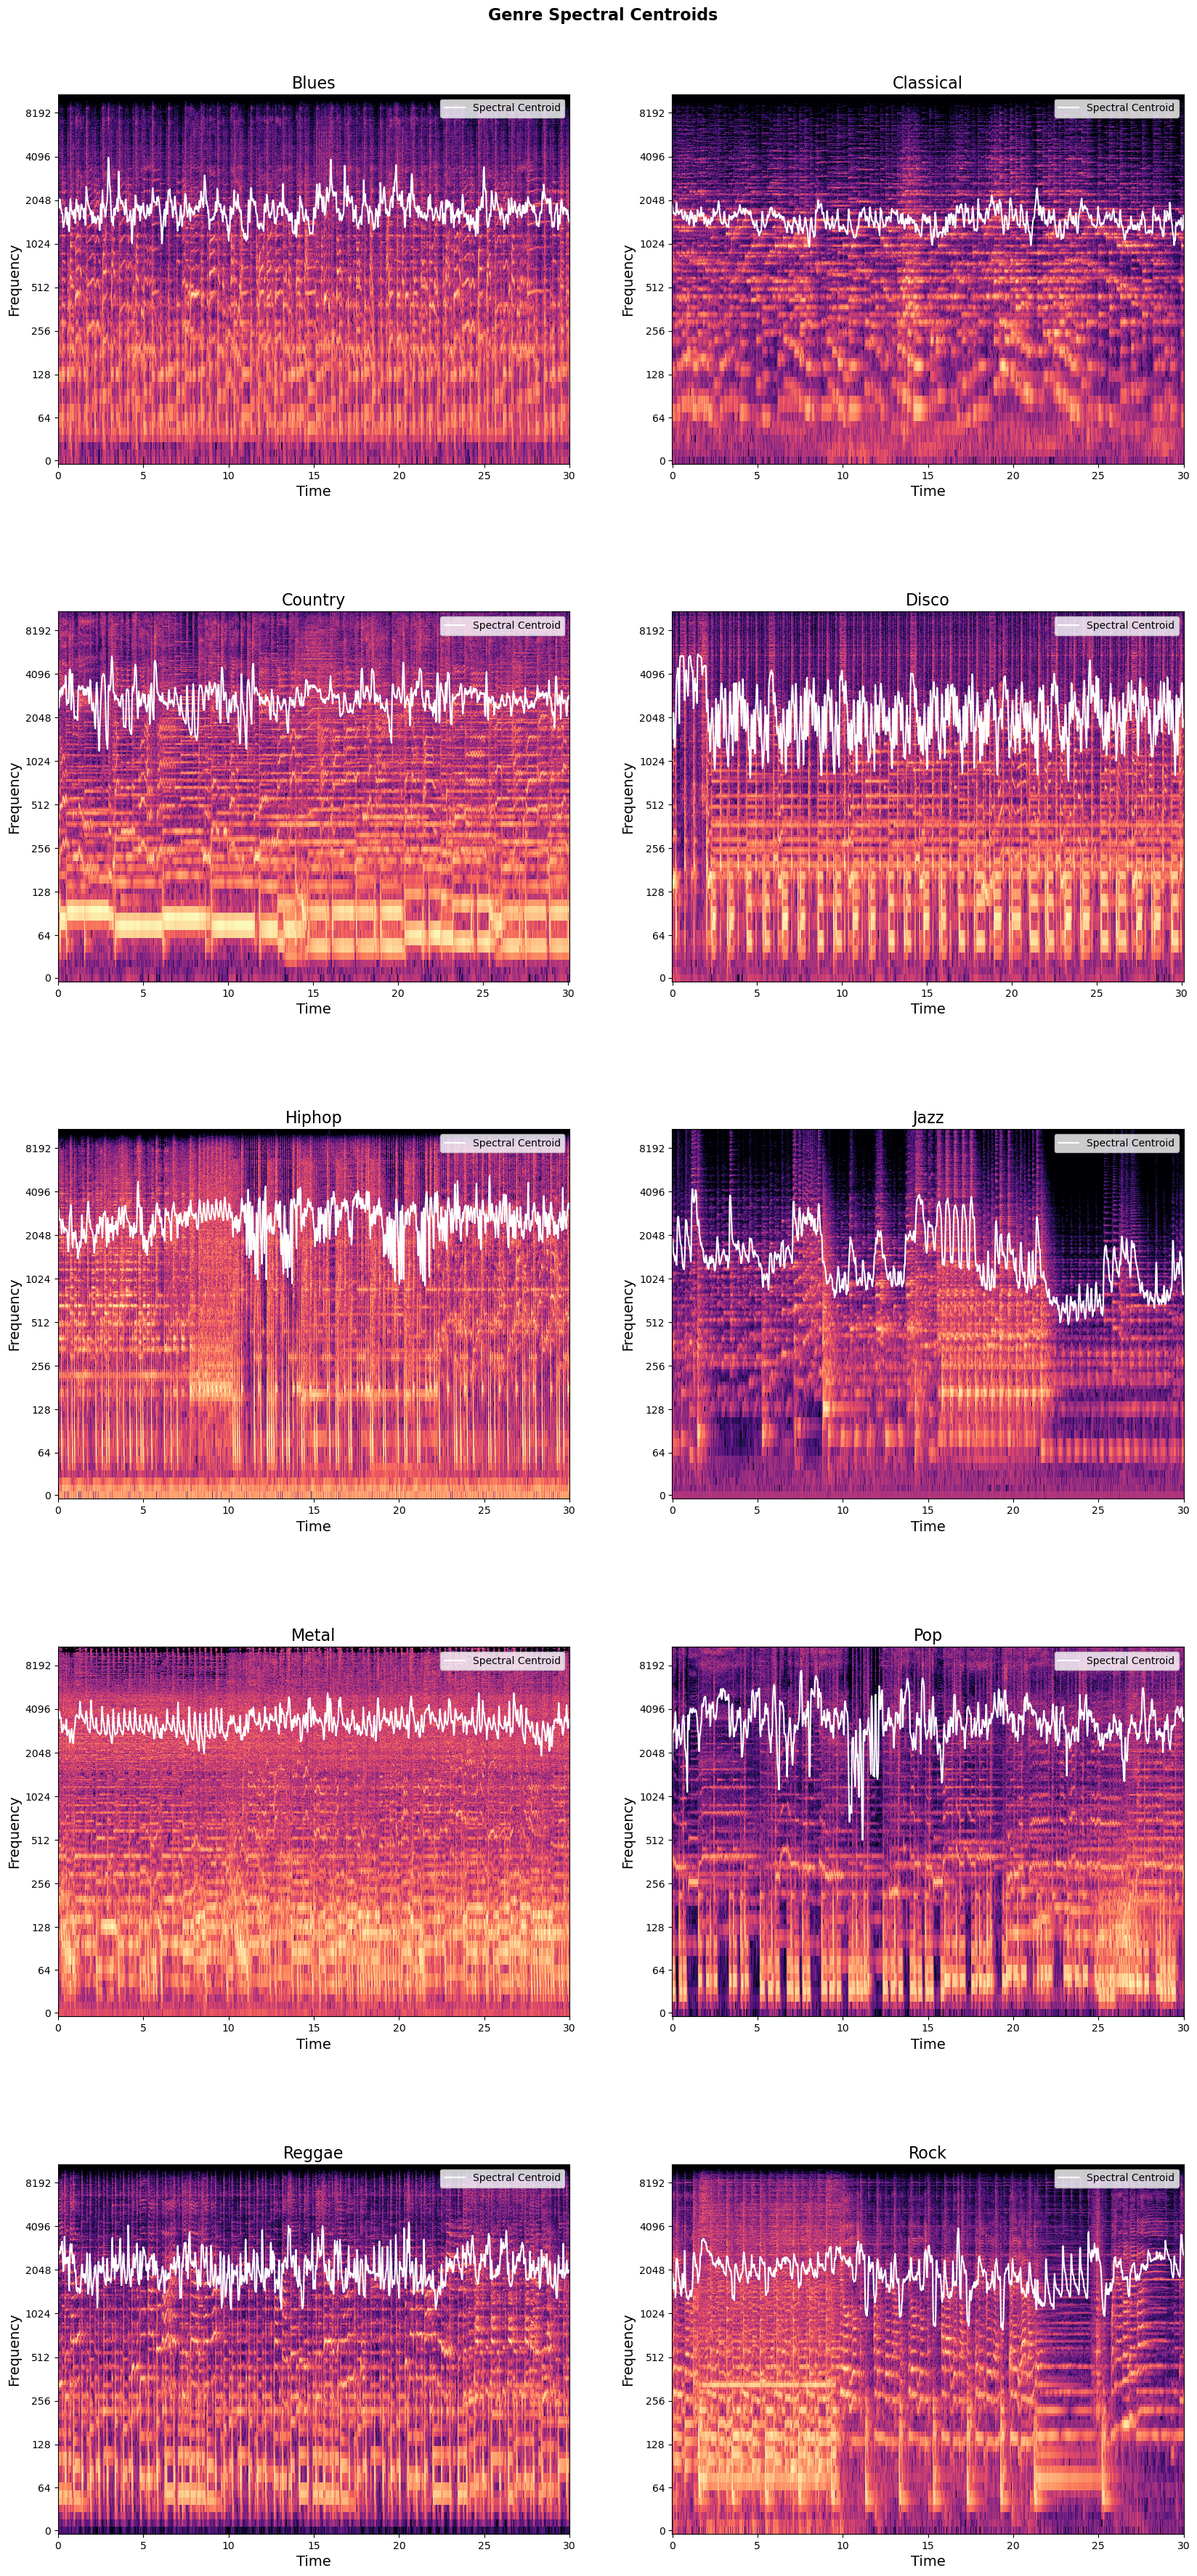

In [355]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 40))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Genre Spectral Centroids", fontsize=16,fontweight = 'bold')

# plot spectogram and spectral centroid
for genre, ax in zip(folder_list, axs.ravel()):
    audio_path = f'../genres/{genre}/{genre}.00000.au'
    x,sr = librosa.load(audio_path)
    centroid = librosa.feature.spectral_centroid(y=x, sr=sr)
    times = librosa.times_like(centroid)
    S, phase = librosa.magphase(librosa.stft(x))
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
    ax.plot(times, centroid.T, label='Spectral Centroid', color='w')
    ax.legend(loc='upper right')
    ax.set_title(genre.title(), fontsize = 16)
    ax.set_ylabel("Frequency", fontsize = 14)
    ax.set_xlabel("Time", fontsize = 14)
    fig = ax.get_figure()
    fig.subplots_adjust(top=0.95)

plt.show()

Spectrogram and Spectral Centroids of samples from 10 different genres. All samples seem centered in the 1,000 - 4,000 Hz range. Pop, Jazz, and Hip-Hop seem to exhibit the most variation in spectral centroid values. Additionally, this jazz spectogram shows great frequency shifts as time passes evidenced by the vast color changes from left to right. 

## Feature Extraction

In [289]:
#create directories, images, and dataset for modeling

create_directories()

create_images()

df = create_dataset()

In [341]:
#save dataframe
df.to_csv('../data/genre_numerical_data.csv', index = False)

## Exploratory Data Analysis - Part 2

In [342]:
#import data
df = pd.read_csv('../data/genre_numerical_data.csv')

In [343]:
#check dataset
df.head()

file_name  genre  global_tempo  zero_crossings  avg_zc_rate  \
0  blues.00000.au  blues         123.0         55031.0     0.083074   
1  blues.00001.au  blues         108.0         37139.0     0.056064   
2  blues.00002.au  blues         161.0         50563.0     0.076285   
3  blues.00003.au  blues         172.0         22077.0     0.033284   
4  blues.00004.au  blues         136.0         67225.0     0.101487   

   std_zc_rate   avg_rms   std_rms  avg_amplitude_envelope  \
0     0.027707  0.130360  0.053108                0.327602   
1     0.038064  0.095905  0.048758                0.249066   
2     0.031682  0.175599  0.052479                0.444890   
3     0.020516  0.141266  0.079632                0.306623   
4     0.044194  0.091617  0.048034                0.282141   

   std_amplitude_envelope  avg_autocorrelation  std_autocorrelation  \
0                0.140254             0.011075            70.008230   
1                0.140119             0.006277            66.854285   
2                0.151819             0.016946           126.012546   
3                0.171395             0.013196           421.451583   
4                0.167069             0.005601            32.317514   

   avg_rolloff  std_rolloff  avg_max_rolloff  std_max_rolloff  \
0  3805.723030   949.343413      8242.220694       496.300868   
1  3550.713616  1725.778347      8137.793818       701.698961   
2  3042.410115   885.511646      7819.975065       643.534317   
3  2184.879029  1221.915647      7519.101427       949.451247   
4  3579.957471  1253.928347      7630.714363       473.130667   

   avg_min_rolloff  std_min_rolloff  avg_spectral_centroid  \
0        36.404936        10.228686            1784.122641   
1        23.698181        15.095347            1530.261767   
2        66.548089        22.825967            1552.832481   
3        56.497596         9.348418            1070.153418   
4       106.675122        37.731605            1835.128513   

   std_spectral_centroid  avg_spectral_bandwidth  std_spectral_bandwidth  \
0             360.202005             2002.412407              292.975102   
1             613.119490             2038.987608              462.498760   
2             395.564168             1747.754087              276.216244   
3             429.378632             1596.422565              408.107638   
4             585.874983             1748.410759              297.285561   

   avg_chroma_stft  std_chroma_stft  avg_harmonic_comp  std_harmonic_comp  \
0         0.350129         0.297946          -0.000049           0.090402   
1         0.340849         0.308182           0.000141           0.071424   
2         0.363538         0.291987          -0.000002           0.127845   
3         0.404854         0.306592           0.000004           0.138040   
4         0.308526         0.296383          -0.000018           0.069387   

   avg_percussive_comp  std_percussive_comp  avg_spectral_flatness  \
0            -0.000011             0.075528               0.004496   
1            -0.000180             0.055355               0.002298   
2            -0.000020             0.086396               0.002635   
3            -0.000018             0.052071               0.000955   
4            -0.000010             0.055627               0.003240   

   std_spectral_flatness  avg_tonnetz  std_tonnetz  avg_spectral_contrast  \
0               0.005506     0.006428     0.065648              20.523289   
1               0.004853     0.029379     0.068902              20.672486   
2               0.003353     0.024222     0.102312              22.191292   
3               0.001632     0.026663     0.133939              21.423621   
4               0.004356    -0.020948     0.100502              21.459618   

   std_spectral_contrast   avg_mel    std_mel  avg_mfcc_1  std_mfcc_1  \
0               8.763629  4.425542  27.200815 -113.598824   50.688946   
1               8.237830  2.653440  17.322649 -207.523834   88.1425

In [344]:
#examine number of features
df.shape

(1000, 186)

In [359]:
#balance of target variable
df['genre'].value_counts(normalize=True)

blues        0.1
classical    0.1
country      0.1
disco        0.1
hiphop       0.1
jazz         0.1
metal        0.1
pop          0.1
reggae       0.1
rock         0.1
Name: genre, dtype: float64

### Time Domain

In [361]:
#summary statistics
df.groupby('genre')["global_tempo", "zero_crossings", 'avg_zc_rate', 'avg_rms', 'avg_amplitude_envelope'].describe().T

genre                                 blues      classical        country  \
global_tempo           count     100.000000     100.000000     100.000000   
                       mean      123.730000     125.650000     120.520000   
                       std        23.586015      17.886497      23.682018   
                       min        83.000000      92.000000      70.000000   
                       25%       103.000000     112.000000     103.000000   
                       50%       123.000000     123.000000     117.000000   
                       75%       144.000000     136.000000     136.000000   
                       max       172.000000     185.000000     172.000000   
zero_crossings         count     100.000000     100.000000     100.000000   
                       mean    52334.640000   51468.330000   55301.370000   
                       std     23336.316364   17278.350296   20052.037445   
                       min     14379.000000   20897.000000   23429.000000   
                       25%     32020.500000   40071.000000   40047.500000   
                       50%     46904.500000   48595.000000   51303.000000   
                       75%     69910.500000   59939.500000   68231.750000   
                       max    111010.000000  110441.000000  140750.000000   
avg_zc_rate            count     100.000000     100.000000     100.000000   
                       mean        0.078969       0.077608       0.083405   
                       std         0.035215       0.026047       0.030209   
                       min         0.021678       0.031221       0.035331   
                       25%         0.048333       0.060441       0.060416   
                       50%         0.070772       0.073346       0.077411   
                       75%         0.105474       0.090403       0.103006   
                       max         0.167504       0.166661       0.212394   
avg_rms                count     100.000000     100.000000     100.000000   
                       mean        0.136067       0.042931       0.125995   
                       std         0.052000       0.036859       0.049194   
                       min         0.051329       0.005257       0.022701   
                       25%         0.099439       0.020078       0.092206   
                       50%         0.126287       0.031810       0.114444   
                       75%         0.168244       0.044889       0.148762   
                       max         0.270814       0.189830       0.274437   
avg_amplitude_envelope count     100.000000     100.000000     100.000000   
                       mean        0.352441       0.113577       0.337295   
                       std         0.149634       0.099048       0.126810   
                       min         0.107726       0.012501       0.055011   
                       25%         0.250433       0.051579       0.247442   
                       50%         0.320550       0.086586       0.313679   
                       75%         0.411705       0.124195       0.416257   
                       max         0.750545       0.512166       0.646360   

genre                                 disco         hiphop           jazz  \
global_tempo           count     100.000000     100.000000     100.000000   
                       mean      119.880000     110.100000     119.570000   
                       std        12.247680      20.997114      18.638103   
                       min        89.000000      86.000000      83.000000   
                       25%       112.000000      96.000000     103.000000   
                       50%       123.000000     103.000000     117.000000   
                       75%       129.000000     117.000000     129.000000   
                       max       161.000000     185.000000     172.000000   
zero_crossings         count     100.000000     100.000000     100.000000   
                       mean    85768.330000   71766.720000   51046.06000

* Global tempo appears to be relatively consistent overall. Pop and Hip-Hop on average have the slowest songs.
* Metal, Hip-Hop, and Disco have the highest amount of zero crossings on average. This could be due to the heavy emphasis on percusion in these genres.
* Classical and Jazz by far have the lowest average root mean squared energy and amplitude envelope. This is reinforced by the wave forms above. Both these genres are notable for having movements within pieces with immense variation in loudness and instrument count.

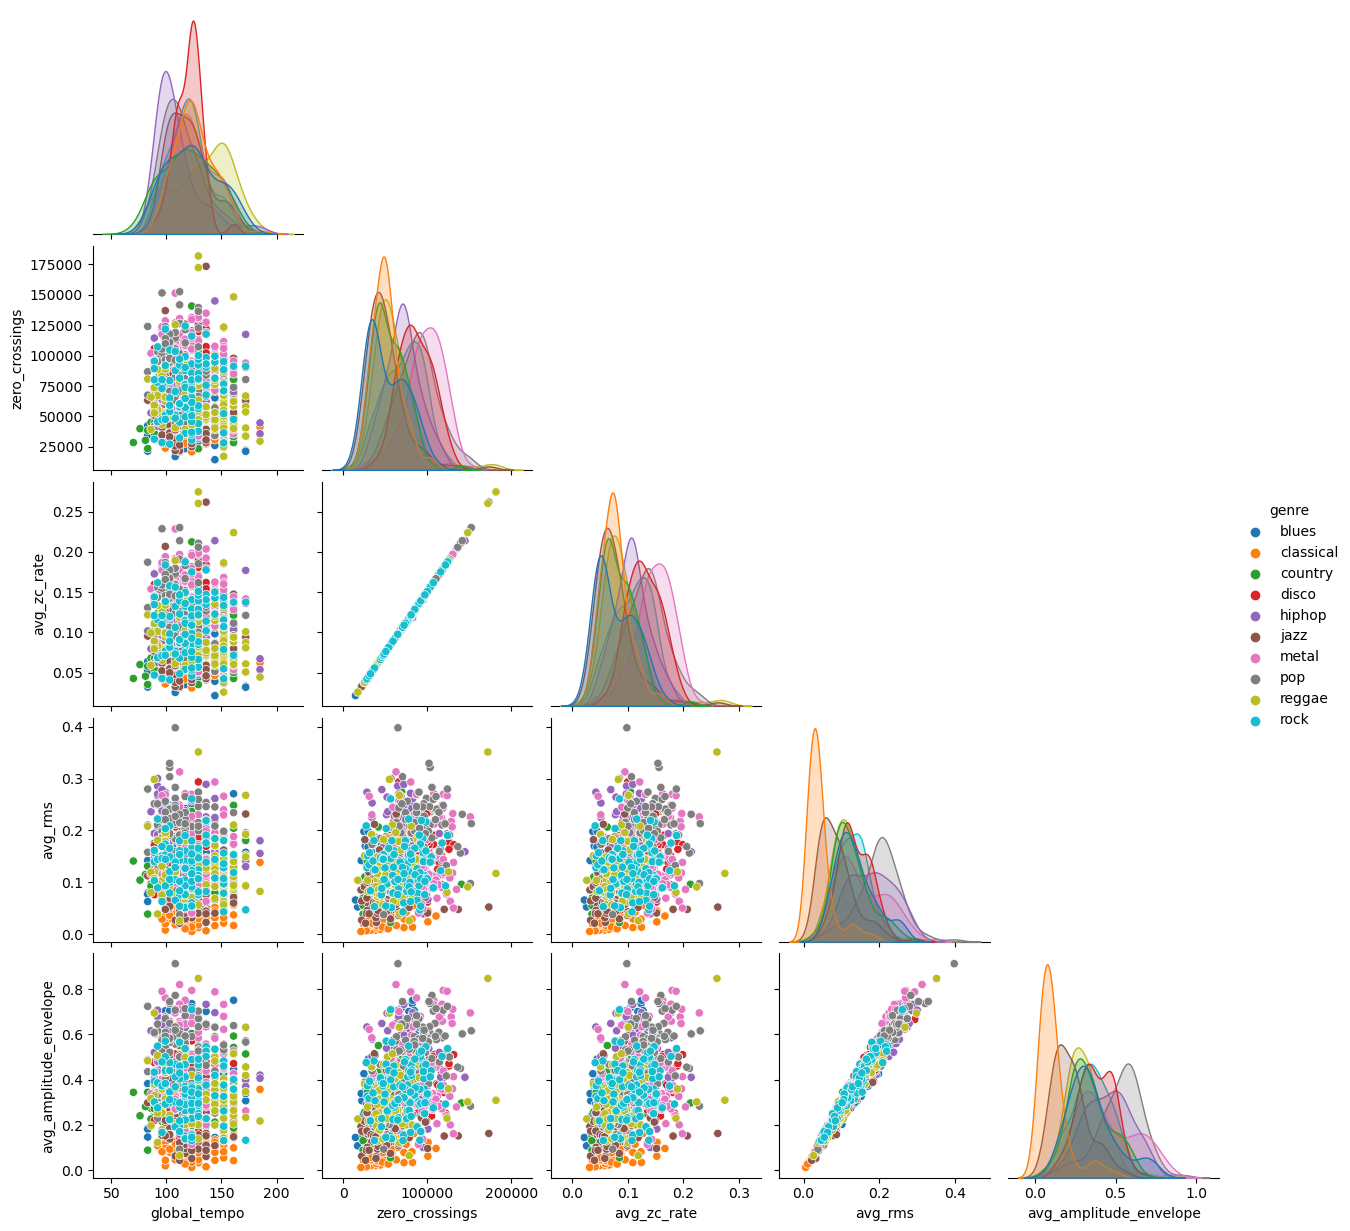

In [368]:
df_time = df[["global_tempo", "zero_crossings", 'avg_zc_rate', 'avg_rms', 'avg_amplitude_envelope', 'genre']]
sns.pairplot(data = df_time,
             hue = 'genre', corner = True);

As expected, there is a high positive correlation between zero crossings and average zero crossing rate. Root mean Squared Energy and Amplitude Envelope both measure loudness. Their positive correlation is also to be assumed.

### Time-Frequency Domain

In [369]:
#summary statistics
df.groupby('genre')["avg_rolloff", "avg_spectral_centroid", 'avg_spectral_bandwidth',
                    'avg_harmonic_comp', 'avg_percussive_comp'].describe().T

genre                                blues    classical       country  \
avg_rolloff            count  1.000000e+02   100.000000  1.000000e+02   
                       mean   3.637110e+03  2482.706120  3.949866e+03   
                       std    1.160353e+03   750.830843  1.293080e+03   
                       min    9.293001e+02   749.740169  1.446105e+03   
                       25%    2.731994e+03  2100.047285  3.093566e+03   
                       50%    3.565336e+03  2476.026920  3.713645e+03   
                       75%    4.688449e+03  2824.757363  4.809455e+03   
                       max    5.770832e+03  4993.363284  7.442153e+03   
avg_spectral_centroid  count  1.000000e+02   100.000000  1.000000e+02   
                       mean   1.727631e+03  1354.059104  1.896335e+03   
                       std    5.154578e+02   348.053838  5.758725e+02   
                       min    5.703499e+02   690.530040  8.581117e+02   
                       25%    1.316946e+03  1171.171864  1.507651e+03   
                       50%    1.630765e+03  1345.214899  1.767262e+03   
                       75%    2.162398e+03  1518.905696  2.258024e+03   
                       max    2.839887e+03  2423.332335  3.760408e+03   
avg_spectral_bandwidth count  1.000000e+02   100.000000  1.000000e+02   
                       mean   1.931392e+03  1521.969151  2.099625e+03   
                       std    3.302062e+02   254.085891  4.452391e+02   
                       min    9.955059e+02   900.409298  1.195985e+03   
                       25%    1.673142e+03  1371.095035  1.800687e+03   
                       50%    1.973527e+03  1520.741199  2.036376e+03   
                       75%    2.190429e+03  1620.488203  2.374493e+03   
                       max    2.531224e+03  2435.894942  3.052844e+03   
avg_harmonic_comp      count  1.000000e+02   100.000000  1.000000e+02   
                       mean  -4.582771e-04    -0.000246 -1.417627e-05   
                       std    1.477277e-03     0.000609  5.463479e-05   
                       min   -1.128540e-02    -0.003960 -3.064881e-04   
                       25%   -2.525293e-05    -0.000584 -3.386279e-06   
                       50%   -4.492123e-06    -0.000022 -7.497909e-07   
                       75%    7.747259e-07    -0.000002  1.746450e-06   
                       max    1.507605e-04     0.001142  1.037117e-04   
avg_percussive_comp    count  1.000000e+02   100.000000  1.000000e+02   
                       mean  -5.652453e-04    -0.000183 -1.289196e-04   
                       std    1.428845e-03     0.000407  4.420286e-04   
                       min   -6.412957e-03    -0.002205 -1.557011e-03   
                       25%   -1.981841e-04    -0.000215 -4.136750e-05   
                       50%   -5.985930e-05    -0.000048 -1.347762e-05   
                       75%   -1.714704e-05    -0.000008 -8.274619e-07   
                       max    1.089384e-03     0.000843  7.306179e-04   

genre                               disco       hiphop          jazz  \
avg_rolloff            count   100.000000   100.000000  1.000000e+02   
                       mean   5520.029470  5333.861946  3.750530e+03   
                       std    1039.723315  1004.825629  1.555950e+03   
                       min    3238.865205  3095.094020  1.134090e+03   
                       25%    4887.666565  4763.259442  2.686078e+03   
                       50%    5362.883374  5317.248962  3.463674e+03   
                       75%    6150.232903  5970.653576  4.439243e+03   
                       max    8074.817942  7642.421898  8.257484e+03   
avg_spectral_centroid  count   100.000000   100.000000  1.000000e+02   
                       mean   2619.968722  2524.611712  1.792498e+03   
                       std     478.776013   479.242776  6.805879e+02   
                       min    1710.975034  1470.293867  7.494466e+02   
                       25%    2289.264259  2243.873211  1.315556e+03  

* There is noticeable variation in average spectral rolloff. In this context, the value represents the 85th percentile of frequencies present. Pop, Hip-Hop, and Disco have the highest values meaning there on average there are more high frequencies present.
* There is also notable variation in the spectral centroid. Classical, Blues, and Jass on average have the lowest values. This may be due to the reduced emphasis on vocals and percussion.
* It's not a coincidence that some of the genres with the lowest rolloff values also have the smallest bandwidth values. There will be smaller variation amongst the frequencies when the range is small. 
* Pop has both the lowest average harmonic component and lowest average percussive component. This may be due to the wide variation within the genre.

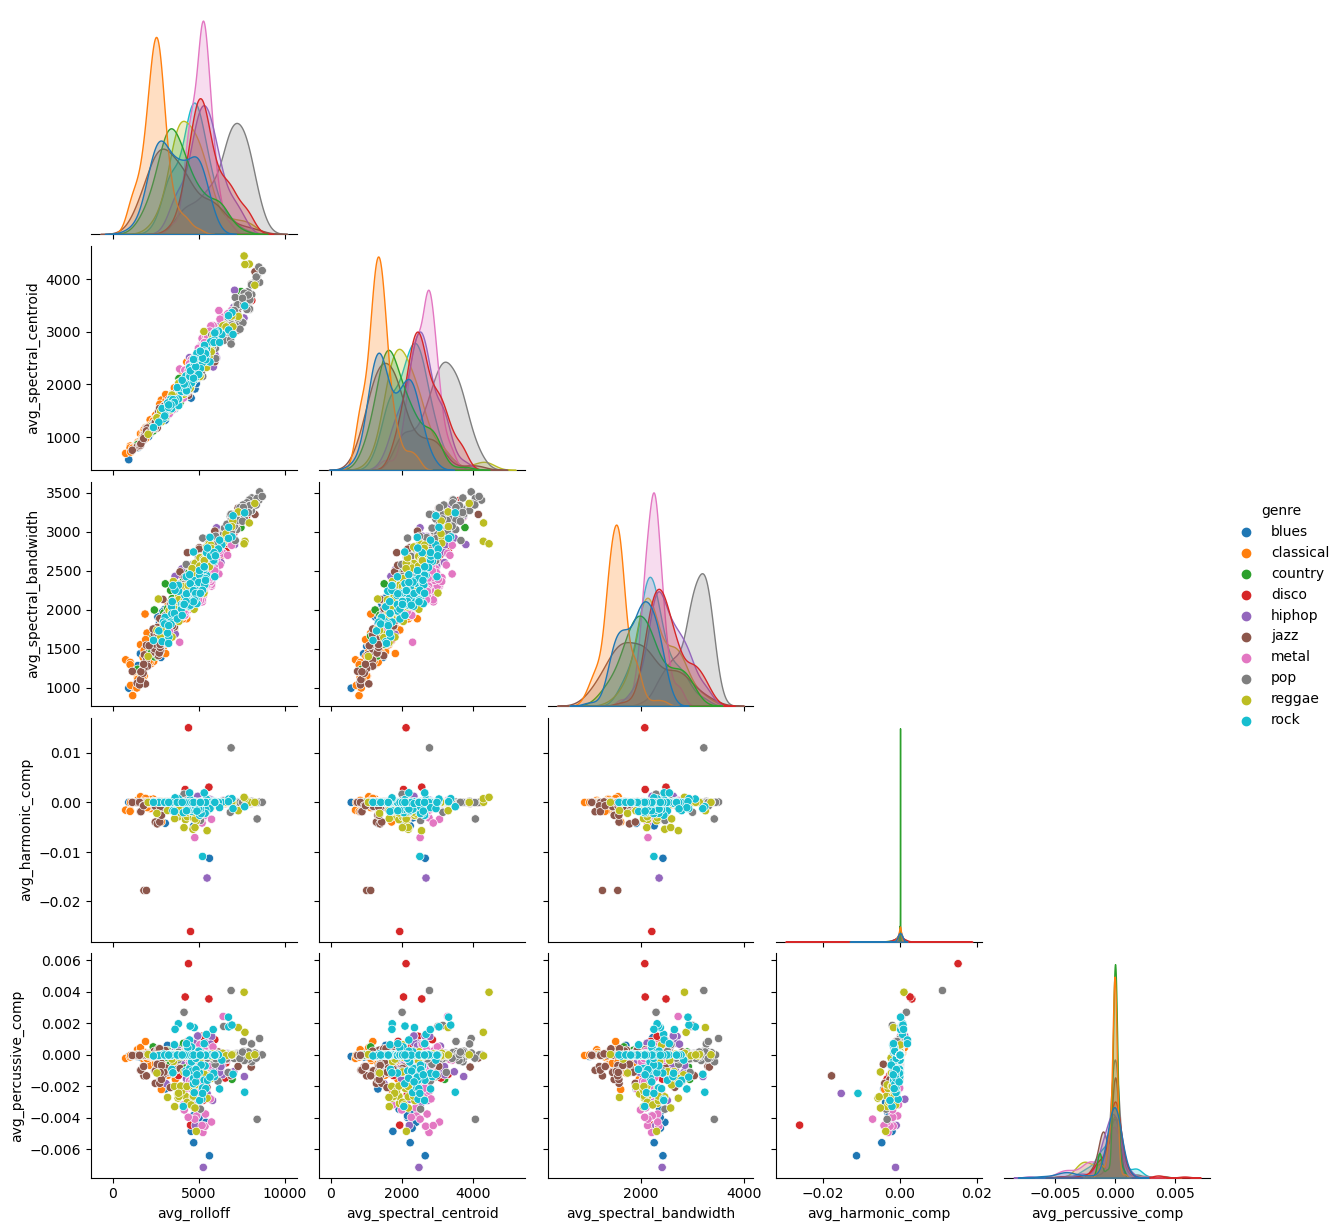

In [370]:
df_tf = df[["avg_rolloff", "avg_spectral_centroid", 'avg_spectral_bandwidth',
                    'avg_harmonic_comp', 'avg_percussive_comp', 'genre']]
sns.pairplot(data = df_tf,
             hue = 'genre', corner = True);

As expected, there is high positive correlation among spectral centroid, bandwidth, and rolloff. Interestingly, the average harmonic and percussive component seemed centered on similar values. There seems to be no correlation between average harmonic components and the spectral values. 

## Summary

Overall, there are several features that highlight the differences among genres. Some concerns are the high correlation among certain features and the small total amount of observations in the data set.